#### Trial seperation code:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import matplotlib.patches as patches
import math
import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression as mi_skl
import seaborn as sns
from scipy import stats
import time
from matplotlib import gridspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import math
import matplotlib.patches as patches
from arena import *
import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from sklearn.feature_selection import mutual_info_regression as mi_skl
import seaborn as sns
from scipy import stats
import time
from matplotlib import gridspec
from math import pi
from collections import Counter
from scipy.spatial import distance


def sandwell_loc(video, fta = 400):
    print(video)
    cap = cv2.VideoCapture(video)
    sandwell_status = 'n'
    fta = fta
    while sandwell_status != 'y':
        for i in list(np.arange(1,3000,fta)):
            cap.set(1, i)
            ret, img = cap.read()
            img1 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            img = cv2.addWeighted(img1,(i/(i+1)),img1,(1/(i+1)),0)

        img = cv2.addWeighted(img,.8,img,.8,0)
        img[:,:270]=cv2.addWeighted(img[:,:270],0,img[:,:270],0,0)
        img[:,1150:]=cv2.addWeighted(img[:,1150:],0,img[:,1150:],0,0)
        gray_blurred = cv2.blur(img, (3, 3)) 

        sandwells = cv2.HoughCircles(gray_blurred,  
                                   cv2.HOUGH_GRADIENT, 1, 100, param1 = 50, 
                                   param2 = 25, minRadius = 15, maxRadius = 20)
        # Convert the circle parameters a, b and r to integers. 
        sandwells = np.uint16(np.around(sandwells))  
  
        if len(sandwells[0])==6:
            for pt in sandwells[0, :]: 
                    x, y, r = pt[0], pt[1], pt[2]
                    cv2.circle(img1, (x, y), r+10, (255, 0,0), 2)
            
            plt.figure(figsize=(4,4))
            plt.imshow(img1)
            plt.show()
            sandwell_status = input("Are all sandwells correct - y/n?")
            fta += 20
            
        else:
            fta+=20
    return sandwells, img

def get_corners(video):
    corners = [0]
    fta = 400
    while len(corners) < 8:
        sandwells, img = sandwell_loc(video, fta)
        step =155
        y_min= min(sandwells[0,:][:,1])-step
        y_max= max(sandwells[0,:][:,1])+step
        x_min= min(sandwells[0,:][:,0])-step
        x_max= max(sandwells[0,:][:,0])+step

        img_cropped=img[y_min:y_max, x_min:x_max]
        img_gray = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)    
        img_cropped = cv2.blur(img_cropped, (8, 8)) 

        mask = np.ones(img_cropped.shape)
        mask[0:,100:650] = 0; mask[100:650:,0:] = 0
        mask = cv2.cvtColor(np.uint8(mask), cv2.COLOR_GRAY2BGR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        corners = cv2.goodFeaturesToTrack(img_cropped, 8, 0.1, 50, mask = mask, blockSize = 8)   
        corners = np.int0(corners)
        fta+=20
        
    for i in corners:
        x,y = i.ravel()
        img_gray=cv2.circle(img_gray,(x+x_min,y+y_min),5,(0,255,0),-1)

    for pt in sandwells[0, :]: 
            x, y, r = pt[0], pt[1], pt[2]
            cv2.circle(img_gray, (x, y), r+10, (255, 0,0), 2)
    
    Nx = [600,800]; Ny = [0,200]; Nwx = Nx[1]-Nx[0]; Nwy = Ny[1]-Ny[0]
    Ex = [200,270]; Ey = [590,750]; Ewx = Ex[1]-Ex[0]; Ewy = Ey[1]-Ey[0]
    Sx = [600,800]; Sy = [850,1100]; Swx = Sx[1]-Sx[0]; Swy = Sy[1]-Sy[0]
    Wx = [1100,1275]; Wy = [300,450]; Wwx = Wx[1]-Wx[0]; Wwy = Wy[1]-Wy[0]
    
    plt.figure(figsize=(2,2))
    
    plt.imshow(img_gray, cmap='gray')
    rectN = patches.Rectangle((Nx[0], Ny[0]), Nwx, Nwy, linewidth=0.2, edgecolor='r', fc='none')
    rectE = patches.Rectangle((Ex[0], Ey[0]), Ewx, Ewy, linewidth=0.2, edgecolor='r', fc='none')
    rectS = patches.Rectangle((Sx[0], Sy[0]), Swx, Swy, linewidth=0.2, edgecolor='r', fc='none')
    rectW = patches.Rectangle((Wx[0], Wy[0]), Wwx, Wwy, linewidth=0.2, edgecolor='r', fc='none')
    plt.show()

    new_corners=np.array([corners.item(i) for i in range(len(corners)*2)]).reshape(8,2)
    new_corners[:,0]=new_corners[:,0]+x_min
    new_corners[:,1]=new_corners[:,1]+y_min
            
    return sandwells[0][:,:2], new_corners


def arena_coodinates(BEHvid):
    #Extract sandwells & corners coordinates
    sandwells, corners = get_corners(BEHvid)
    cx = corners[:,0]
    cy = corners[:,1]
    
    
    bl_x = min(cx); bl_y = min(cy) #bl = bottom left corner
    tr_x = max(cx); tr_y = max(cy) #tr = top right corner
    w_x = tr_x - bl_x;  w_y = tr_y - bl_y #w = width
    
    cxn_x = bl_x #correction factor x
    cxn_y = bl_y #correction factor y
    
    #correct corners & sws
    bl_x -= cxn_x; bl_y -= cxn_y
    tr_x -= cxn_x; tr_y -= cxn_y
    w_x = tr_x - bl_x; w_y = tr_y - bl_y
    sw_x = sandwells[:,0] - cxn_x; sw_y = sandwells[:,1] - cxn_y

    return bl_x, bl_y, tr_x, tr_y, w_x, w_y, sw_x, sw_y, cxn_x, cxn_y

def startbox_indexs(META, bl_y, tr_x, tr_y, bl_x):
    """Defines the indexes of all startbox activity"""
    #Identify the startbox
    if ego_allo == 'Ego':
        SBS = [META['Combo'].values[0][0]]
    else: #ADAPT FOR ALLO TOO
        SBS = [META['Combo'].values[0][0], META['Combo'].values[0][1]]
    RW = META['Rewarded well'].values[0]

    #Define Starting SB xy coordinates
    SBS_idxs = []
    if 'N' in SBS:
        SB_idxs = list(META[META['cap_y'] < bl_y].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'N'
    if 'E' in SBS:
        SB_idxs = list(META[META['cap_x'] > tr_x].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'E'
    if 'S' in SBS:
        SB_idxs = list(META[META['cap_y'] > tr_y].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'S'
    if 'W' in SBS:
        SB_idxs = list(META[META['cap_x'] < bl_x].index)
        SBS_idxs += SB_idxs
        META.loc[SB_idxs, 'Location'] = 'W'
    MetaSB = META.loc[SBS_idxs].sort_index()
    return MetaSB, SBS, RW

def sw_naming(sw_x, sw_y):
    """Names each of the six sandwells based on the SW coordinate input"""
    sw_xord = np.array(sorted(sw_x.copy()))
    sw_yord = np.array(sorted(sw_y.copy()))
    for i in range(6):
        if sw_x[i] in sw_xord[:2] and sw_y[i] in sw_yord[:2]:
            SW1 = [sw_x[i], sw_y[i]]
        elif sw_x[i] in sw_xord[-2:] and sw_y[i] in sw_yord[:2]:
            SW2 = [sw_x[i], sw_y[i]]
        elif sw_x[i] in sw_xord[:2] and sw_y[i] in sw_yord[-2:]:
            SW5 = [sw_x[i], sw_y[i]]
        elif sw_x[i] in sw_xord[-2:] and sw_y[i] in sw_yord[-2:]:
            SW6 = [sw_x[i], sw_y[i]]
        elif sw_x[i] - sw_xord[0] < sw_xord[-1] - sw_x[i]:
            SW3 = [sw_x[i], sw_y[i]]
        else:
            SW4 = [sw_x[i], sw_y[i]]
    return {1:SW1, 2:SW2, 3:SW3, 4:SW4, 5:SW5, 6:SW6}

def Trial_indexes(MetaSB, SB_thresh):
    """Indexes for each SAM/CHO trial"""
    SB1 = META['Combo'].values[0][0]
    if ego_allo == 'Ego':
        MetaSB = MetaSB[MetaSB['Location'] == SB1]
        SB2 = META['Combo'].values[0][0]
    else:
        SB2 = META['Combo'].values[0][1]
        MetaSB = MetaSB[MetaSB['Location'].isin([SB1, SB2])]

    #first Trial
    TR_idxs = []; start = MetaSB.index[0]
    for i, idx in enumerate(MetaSB.index):
        if i > 0:
            if idx - MetaSB.index[i-1] > SB_thresh*20: #Jump in index (Possible trial end)
                if ego_allo == 'Allo' and len(TR_idxs) == 0 and MetaSB.loc[idx]['Location'] == SB2:
                    if MetaSB.index[i+(SB_thresh*20)] - idx <= SB_thresh*20:
                        TR_idxs.append(np.arange(start,idx-1,1))
                        start = idx
                        MetaSB = MetaSB[MetaSB['Location'] == SB2]
                        break
                elif ego_allo == 'Ego':
                    if idx - MetaSB.index[i-1] > SB_thresh*20:
                        TR_idxs.append(np.arange(start,idx-1,1))
                        start = idx
    #Second Trial     
    for i, idx in enumerate(MetaSB.index):
        if idx > start:
            if idx - MetaSB.index[i-1] > SB_thresh*20: #Jump in index (Possible trial end)
                if ego_allo == 'Allo' and len(TR_idxs) > 0:  
                    if MetaSB.index[i+(SB_thresh*20)] - idx <= SB_thresh*20:
                        TR_idxs.append(np.arange(start,idx-1,1))
                        
    
    return TR_idxs

C:\Users\fr87_\OneDrive - University of Edinburgh\arena room files\ANALYSIS 2.0\Code\Gobbo et al. Code\Example Data\H2226\P1Allo\BEH\H2226_A28_CHO_BEH.flv


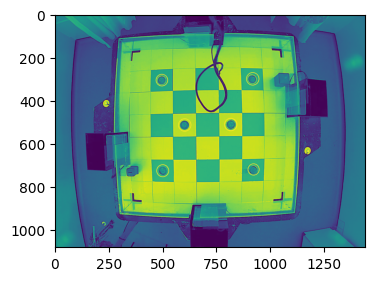

Are all sandwells correct - y/n? y


C:\Users\fr87_\AppData\Local\Temp\ipykernel_29744\1885930751.py:95: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  corners = np.int0(corners)


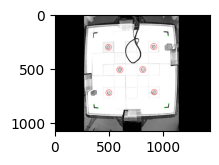

TypeError: string indices must be integers, not 'str'

In [10]:
# 1. Read in your DLC file and call it "META"

file='H2226_A28_WN6_CHO1_DLC.csv'

Animal_ID, E_ASession, Combo, Stage, Ext =file.split('_')
E_A=E_ASession[0]
ego_allo=['Ego' if E_A=='E' else 'Allo']
Session=E_ASession[1:]
Stage=Stage[:-1]

codeDir=r'C:\Users\fr87_\OneDrive - University of Edinburgh\arena room files\ANALYSIS 2.0\Code\Gobbo et al. Code'
META = codeDir+'\\Example Data\\H2226\\P1Allo\\DLC\\'+ file #<-------Add file loc of animal coordinates

#2. Read in the BEH video file
BEHdir=codeDir+'\\Example Data\\H2226\\P1Allo\\BEH'
BEHvid = BEHdir+'\\%s_%s_%s_BEH.flv' %(Animal_ID, E_A+Session, Stage) #Read in BEH vid

#3. Extract key coordinates: bottom left (bl) corner, top right (tr) corner, width (w), sand well (sw) 
bl_x, bl_y, tr_x, tr_y, w_x, w_y, sw_x, sw_y, cxn_x, cxn_y = arena_coodinates(BEHvid)

#4. Define SBs & SWS
MetaSB, SBS, RW = startbox_indexs(META, bl_y, tr_x, tr_y, bl_x) #Define SB
SWS = sw_naming(sw_x, sw_y) #Define SWs

#5. #Extract Trial indexes
TR_idxs = Trial_indexes(MetaSB, SB_thresh = 2) 

In [15]:
df=pd.read_csv(META)
df
META['Combo']

TypeError: string indices must be integers, not 'str'